In [24]:
import pyspark
import numpy as np
from pyspark import SparkContext, SparkConf
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
data = np.load('reduced_data_rob.npy')

In [4]:
conf = SparkConf().setAppName("Prova").setMaster("local")
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 09:36:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [82]:
points = list(zip(data[:,0], data[:,1]))
rdd = sc.parallelize(points)
cent = rdd.takeSample(withReplacement=False, num=3) # initial random centroid

In [6]:
def min_distance(x, c:list):
    x, c = np.array(x), np.array(c)
    dist = np.array(list(map(lambda a: np.linalg.norm(a - x)**2, c)))
    return np.argmin(dist)

In [7]:
def squared_distance(x, c:list):
    x, c = np.array(x), np.array(c)
    dist = np.array(list(map(lambda a: np.linalg.norm(a - x)**2, c)))
    return np.min(dist)

In [8]:
def k_means(rdd, cent):
    belong = rdd.map(lambda x: (min_distance(x, cent), x)) # which cluster each data belongs to
    return pd.DataFrame(belong.collect())
    
def centroids(rdd, cent):
    belong = rdd.map(lambda x: (min_distance(x, cent), x)) # which cluster each data belongs to
    count = belong.countByKey()
    summation = belong.reduceByKey(lambda x, y: (x[0]+y[0],  x[1]+y[1])) # pairwise summation over the values
    cent = summation.map(lambda x: (np.array(x[1])/ count[x[0]]))
    return cent.collect()

def var(rdd, cent):
    accum = sc.accumulator(0)
    rdd.map(lambda x: squared_distance(x, cent)).foreach(lambda x: accum.add(x))
    return accum.value

In [9]:
def iterating(k, rdd, threshold = 10):
    cent = rdd.takeSample(withReplacement=False, num=k) # initial random centroid    
    for i in range(20):
        prev_cent = cent
        cent = centroids(rdd, cent)
        distance = np.linalg.norm(np.array(prev_cent)-np.array(cent))
        if distance < threshold:
            break
    variance = var(rdd, cent)
    clusters = k_means(rdd, cent)
    return clusters, variance

In [83]:
sc.setLogLevel("OFF")
l = []
for k in tqdm(range(3, 11)):
    clusters, variance = iterating(k, rdd, threshold = 10)
    l.append(variance)

100%|██████████| 8/8 [16:42<00:00, 125.31s/it]                                  


<AxesSubplot:title={'center':'Elbow Method'}, xlabel='k'>

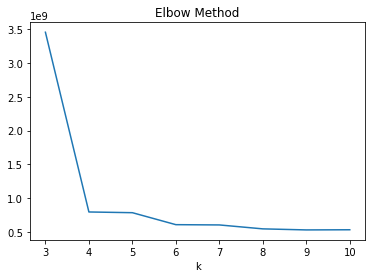

In [87]:
k = pd.DataFrame(l)
k.index = k.index + 3
k.plot(title = 'Elbow Method', legend = False, xlabel = 'k')

k = 4

In [102]:
sc.setLogLevel("OFF")
clusters, variance = iterating(4, rdd)

In [103]:
clusters['x'] = clusters[1].apply(lambda x: x[0])
clusters['y'] = clusters[1].apply(lambda x: x[1])
clusters.rename({0: 'Color'}, inplace = True, axis = 1)

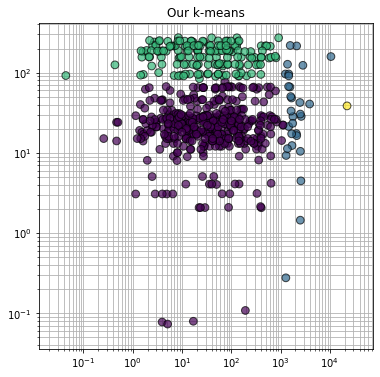

In [125]:
fig, ax = plt.subplots(figsize = (6,6))
plt.grid(True,zorder=0, which="both", ls="-")
ax.scatter(data[:,0], data[:,1], s=60, alpha=0.7, edgecolors="k", zorder=3, c=clusters.Color)
plt.title("Our k-means")
ax.set_yscale("log")
ax.set_xscale("log")

In [116]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='random').fit_predict(data)
kmeanspp = KMeans(n_clusters=4, init='k-means++').fit_predict(data)

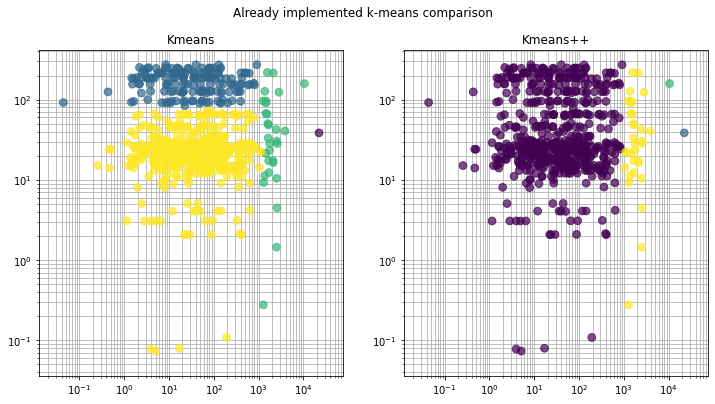

In [129]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle('Already implemented k-means comparison')

ax[0].grid(True,zorder=0, which="both", ls="-")
ax[0].scatter(data[:,0], data[:,1], s=60, alpha=0.7, zorder=3, c=kmeans)
ax[0].set_title('Kmeans')
ax[0].set_yscale("log")
ax[0].set_xscale("log")

ax[1].grid(True,zorder=0, which="both", ls="-")
ax[1].scatter(data[:,0], data[:,1], s=60, alpha=0.7, zorder=3, c=kmeanspp)
ax[1].set_title('Kmeans++')
ax[1].set_yscale("log")
ax[1].set_xscale("log")